In [1]:
import nistats
import nibabel as nib
import nilearn
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn.plotting import plot_stat_map
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl

%matplotlib inline

/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 19

## Load first-levels

In [2]:
onset_shift = -1.5  # NB this is the onset shift that corresponds to the effect of slice timing correction
first_level_models = []
print('loading...', end='')
for sub in np.arange(1,34):
    if sub == 23:
        continue  # doesn't exist
    fn = f'./models_sm/sub-{sub}_shift-{onset_shift}_glm.pkl'
    with open(fn, 'rb') as f:
        model = pkl.load(f)
    first_level_models.append(model)
print('done')

loading...

FileNotFoundError: [Errno 2] No such file or directory: './models_sm/sub-2_shift--1.5_glm.pkl'

## second-level, 5mm smoothing

In [42]:
second_level_model = SecondLevelModel(smoothing_fwhm=5)  # 5mm, cf De Hollander 2017
second_level_model = second_level_model.fit(first_level_models)
z1 = second_level_model.compute_contrast(first_level_contrast='response_left - response_right')

3.2018986110924916


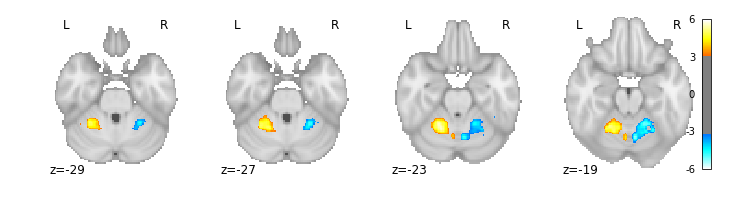

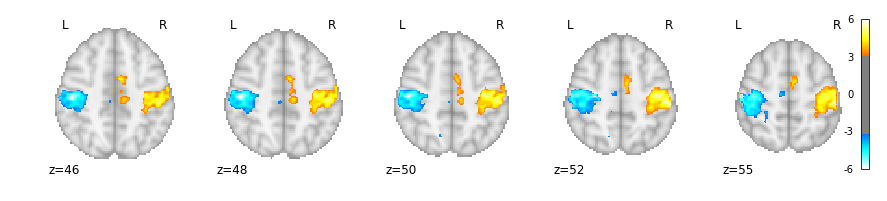

In [65]:
_, threshold = map_threshold(z1, alpha=0.05, height_control='fdr')
print(threshold)
plot_stat_map(z1, display_mode='z', threshold=threshold, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z1, display_mode='z', threshold=threshold, cut_coords=[46, 48, 50, 52, 55])

## second level, less smoothing

In [66]:
second_level_model = SecondLevelModel(smoothing_fwhm=1.5)     # 1 voxel
second_level_model = second_level_model.fit(first_level_models)
z2 = second_level_model.compute_contrast(first_level_contrast='response_left - response_right')

/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:559: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/miniconda3/lib/python3.7/site-packages/nistats/first_level_model.py:559: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


5.110731713505823


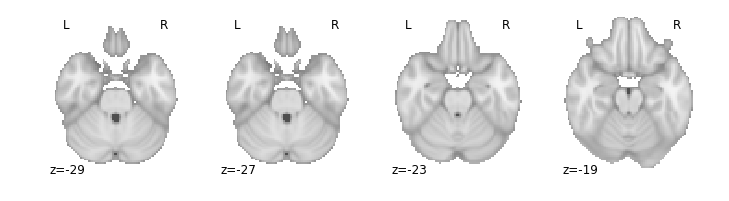

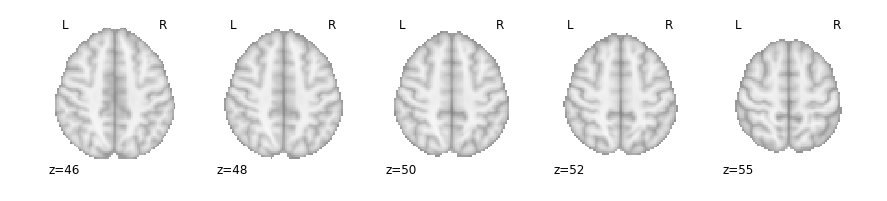

In [69]:
_, threshold = map_threshold(z2, alpha=0.05, height_control='fdr')
print(threshold)

plot_stat_map(z2, display_mode='z', threshold=threshold, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z2, display_mode='z', threshold=threshold, cut_coords=[46, 48, 50, 52, 55])

#### Unfornately the FDR-corrected becomes to high. If we're more liberal, we can find something in line with expectations

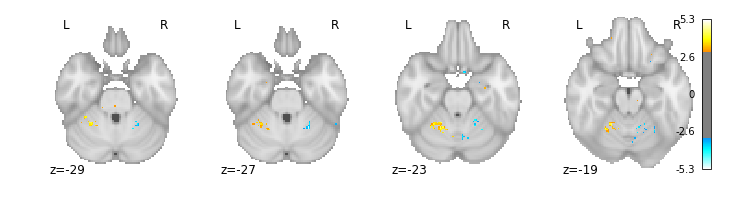

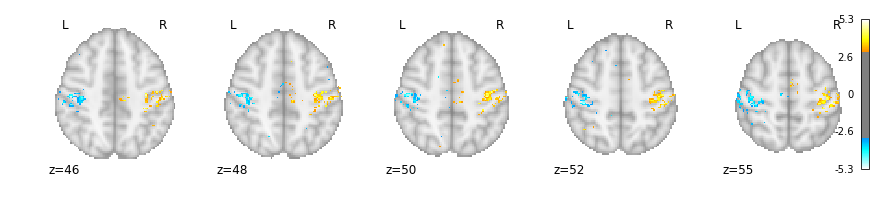

In [70]:
plot_stat_map(z2, display_mode='z', threshold=3.1, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z2, display_mode='z', threshold=3.1, cut_coords=[46, 48, 50, 52, 55])

## second level, no smoothing, liberal threshold

In [46]:
second_level_model = SecondLevelModel(smoothing_fwhm=None)
second_level_model = second_level_model.fit(first_level_models)
z3 = second_level_model.compute_contrast(first_level_contrast='response_left - response_right')

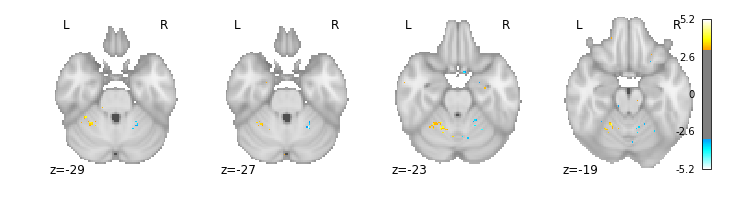

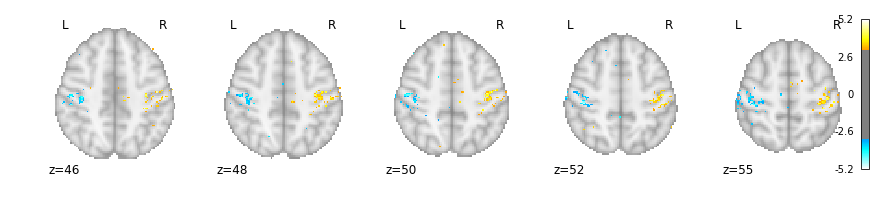

In [71]:
plot_stat_map(z3, display_mode='z', threshold=3.1, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z3, display_mode='z', threshold=3.1, cut_coords=[46, 48, 50, 52, 55])

# Overall: The data seem in line with expectations, finding 'activated' voxels in motor regions in M1 and ipsilateral in cerebellum

### Can we find a difference in overall results between sites?

## Second level, Leipzig only

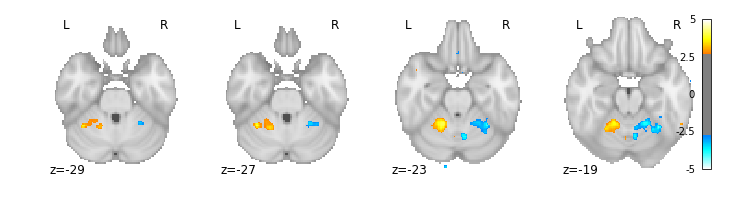

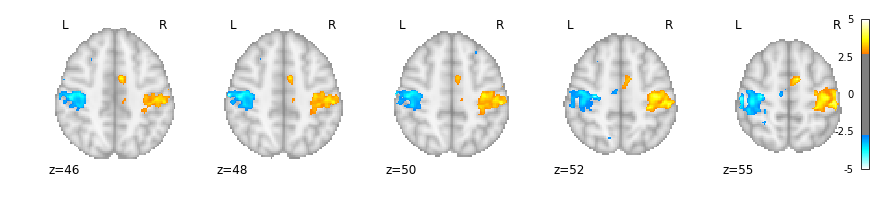

In [16]:
second_level_model_leipzig = SecondLevelModel(smoothing_fwhm=5)  # 5mm, cf De Hollander 2017
second_level_model_leipzig = second_level_model_leipzig.fit(first_level_models[:20])  # 1-19 are Leipzig, 20-34 are Amsterdam [23 misses]
z_leipzig = second_level_model_leipzig.compute_contrast(first_level_contrast='response_left - response_right')

plot_stat_map(z_leipzig, display_mode='z', threshold=2.8, vmax=5, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z_leipzig, display_mode='z', threshold=2.8, vmax=5, cut_coords=[46, 48, 50, 52, 55])

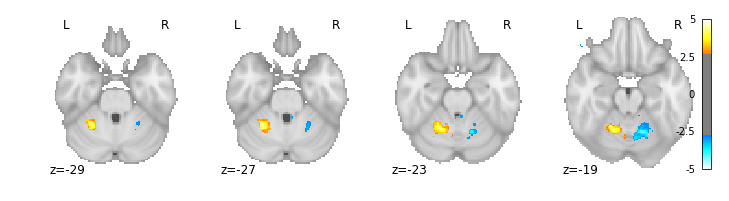

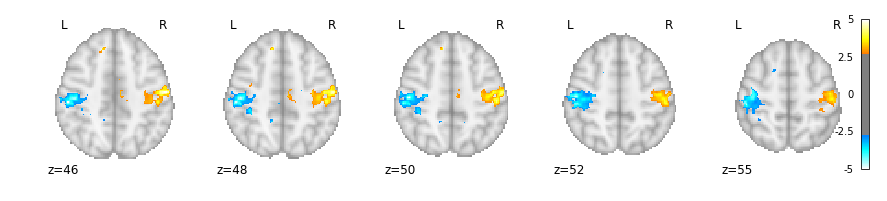

In [18]:
second_level_model_amsterdam = SecondLevelModel(smoothing_fwhm=5)  # 5mm, cf De Hollander 2017
second_level_model_amsterdam = second_level_model_amsterdam.fit(first_level_models[20:])
z_amsterdam = second_level_model_amsterdam.compute_contrast(first_level_contrast='response_left - response_right')

plot_stat_map(z_amsterdam, display_mode='z', threshold=2.8, vmax=5, cut_coords=[-29, -27, -23, -19])
plot_stat_map(z_amsterdam, display_mode='z', threshold=2.8, vmax=5, cut_coords=[46, 48, 50, 52, 55])

#### Eye-balling, there seems to be a small difference, with a bit more focal clusters in the Amsterdam data, and a bit larger clusters in the Leipzig data ('inherent' smoothness?). However, there's also power differences since the Leipzig data consists of 19 subjects vs 14 in  Amsterdam

Let's look at mean first-level z-scores instead, as a measure of (within-subject) "signal-to-noise" values. 

Analyses below makes use of unsmoothed data

In [19]:
first_level_zscores = [x.compute_contrast('response_left - response_right', output_type='z_score') for x in first_level_models]

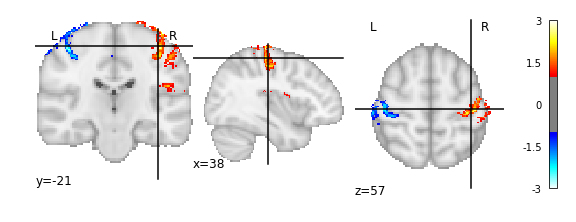

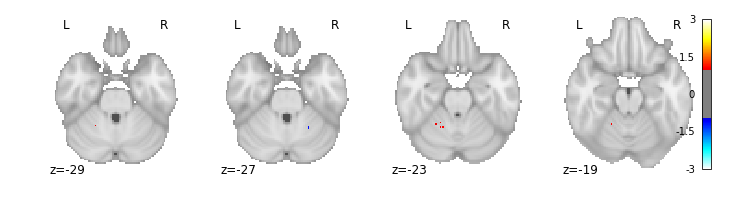

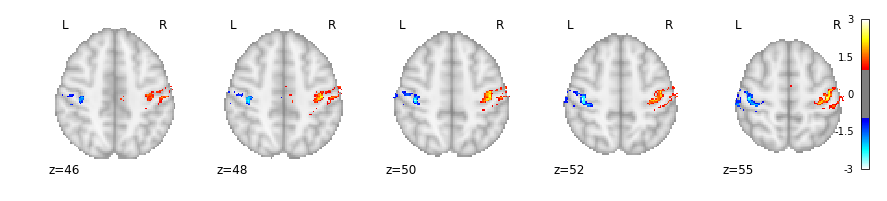

In [20]:
mean_zscore = nilearn.image.mean_img(nilearn.image.concat_imgs(first_level_zscores))
plot_stat_map(mean_zscore, threshold=1, vmax=3)
plot_stat_map(mean_zscore, display_mode='z', threshold=1, vmax=3, cut_coords=[-29, -27, -23, -19])
plot_stat_map(mean_zscore, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55])

## the threshold is abritrary here, only used for visualization purposes

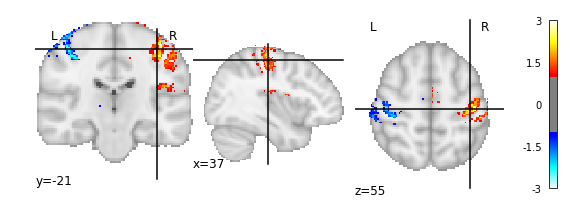

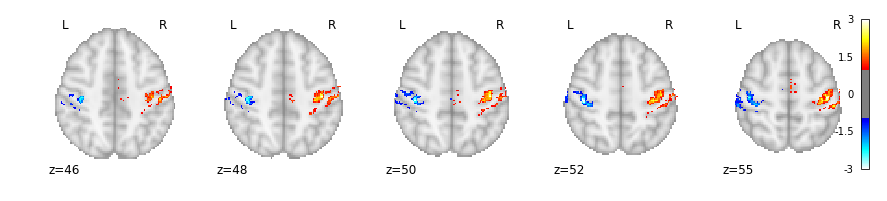

In [21]:
mean_zscore_leipzig = nilearn.image.mean_img(nilearn.image.concat_imgs(first_level_zscores[:20]))
plot_stat_map(mean_zscore_leipzig, threshold=1, vmax=3)
plot_stat_map(mean_zscore_leipzig, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55])

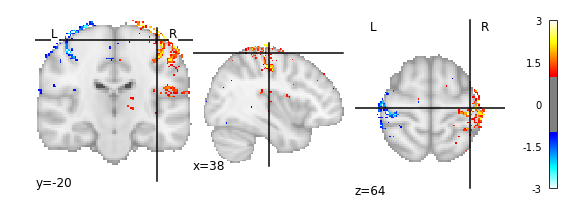

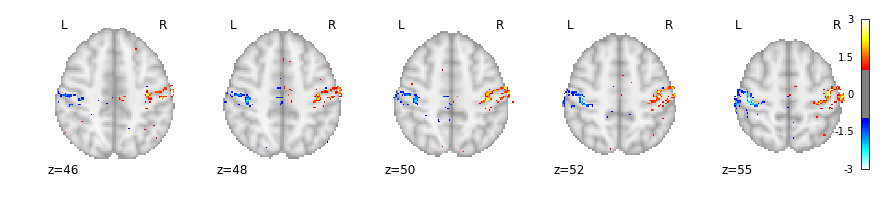

In [22]:
mean_zscore_amsterdam = nilearn.image.mean_img(nilearn.image.concat_imgs(first_level_zscores[20:]))
plot_stat_map(mean_zscore_amsterdam, threshold=1, vmax=3)
plot_stat_map(mean_zscore_amsterdam, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55])

Again, the Amsterdam data seems a bit less smooth (which is good) compared to the Leipzig data. But the results are highly comparable I think.

Taken together, the simple `left<right` clusters seem in line with expectations and, eye-balling, I don't see a reason to believe there's anything wrong with the event onsets as recorded?

## Compare onsets, see if z-values increase or decrease

loading................................done
loading................................done
loading................................done
loading................................done


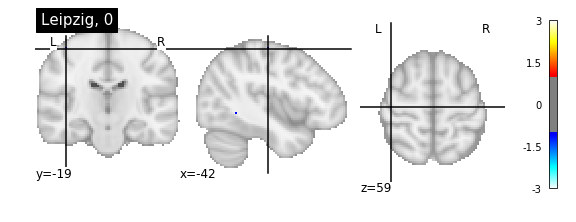

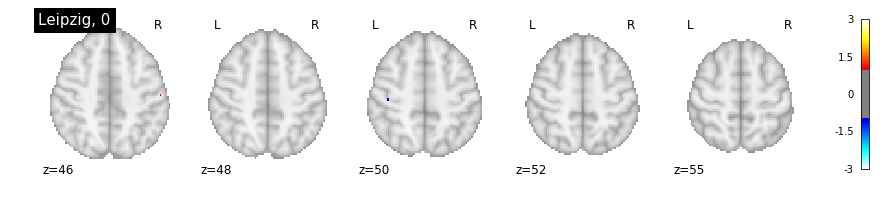

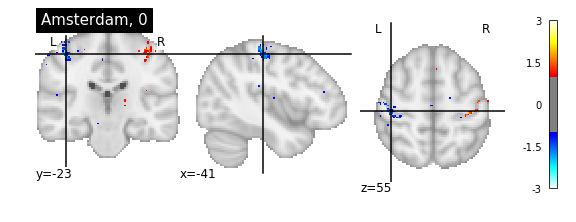

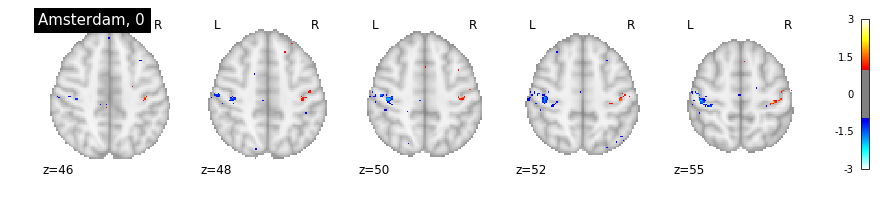

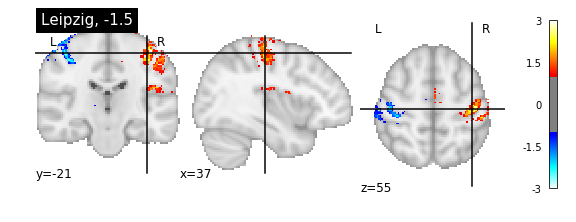

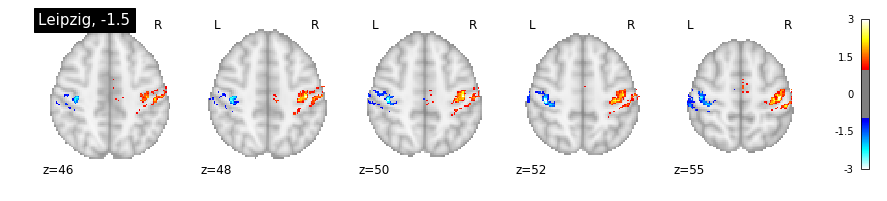

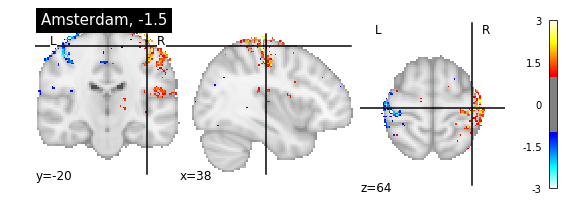

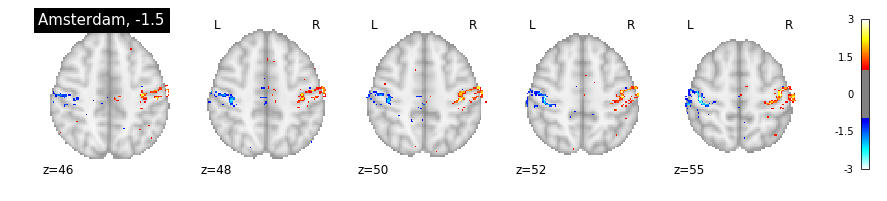

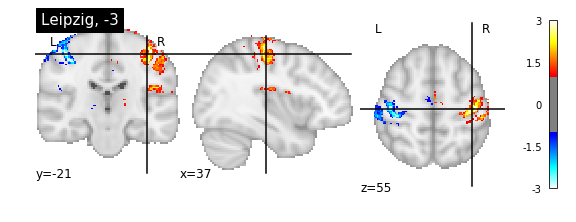

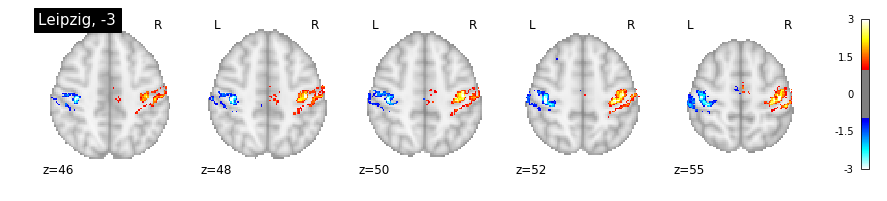

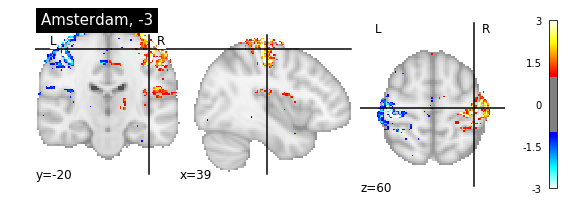

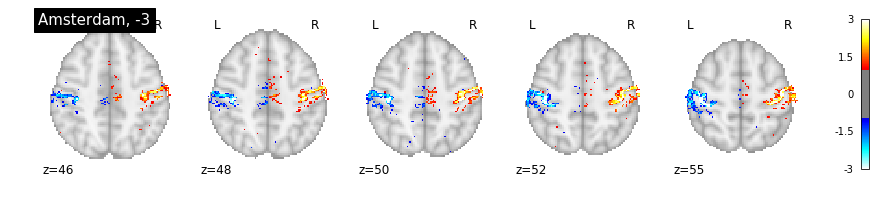

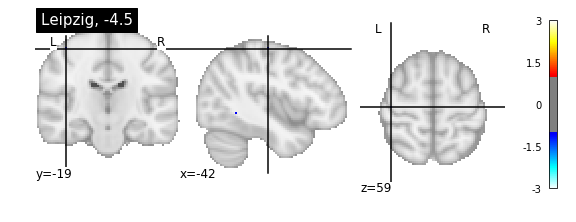

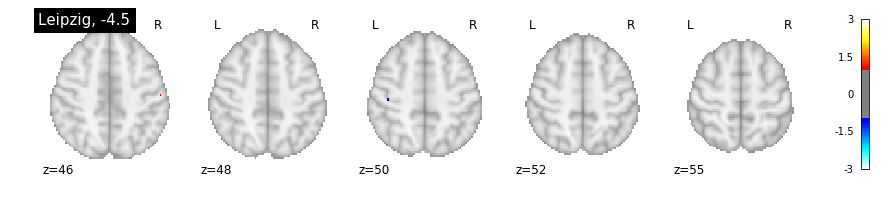

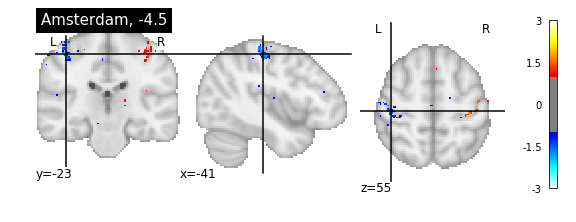

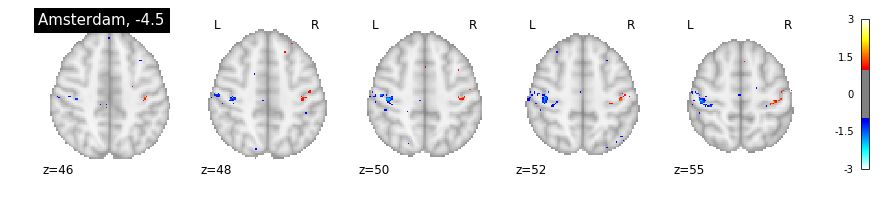

In [7]:
for onset_shift in [0, -1.5, -3, -4.5]: #onset_shift = -3
    first_level_models = []
    print('loading', end='')
    for sub in np.arange(1,34):
        if sub == 23:
            continue  # doesn't exist
        fn = f'./models_sm/sub-{sub}_shift-{onset_shift}_glm.pkl'
        print('.', end='')
        with open(fn, 'rb') as f:
            model = pkl.load(f)
        first_level_models.append(model)
    print('done')

    first_level_zscores = [x.compute_contrast('response_left - response_right', output_type='z_score') for x in first_level_models]

    ## Leipzig
    mean_zscore_leipzig = nilearn.image.mean_img(nilearn.image.concat_imgs(first_level_zscores[:20]))
    plot_stat_map(mean_zscore_leipzig, threshold=1, vmax=3, title='Leipzig, {}'.format(onset_shift))
    plot_stat_map(mean_zscore_leipzig, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55], title='Leipzig, {}'.format(onset_shift))

    ## Amsterdam
    mean_zscore_amsterdam = nilearn.image.mean_img(nilearn.image.concat_imgs(first_level_zscores[20:]))
    plot_stat_map(mean_zscore_amsterdam, threshold=1, vmax=3, title='Amsterdam, {}'.format(onset_shift))
    plot_stat_map(mean_zscore_amsterdam, display_mode='z', threshold=1, vmax=3, cut_coords=[46, 48, 50, 52, 55], title='Amsterdam, {}'.format(onset_shift))

In [ ]:
## Ok so -3 works best, even though -1.5 is "theoretically correct"

In [10]:
print(nib.load('./derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-01_space-T1w_desc-preproc_bold.nii.gz').header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  92 119  91 387   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.0e+00 1.5e+00 1.5e+00 1.5e+00 3.0e+03 1.0e+00 1.0e+00 1.0e+00]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 16
cal_max         : 5154.8384
cal_min         : -491.00537
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'xform matrices modified by FixHeaderApplyTransforms (niworkflows v0.5.2.post5).'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d  

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [8]:
print(nib.load('./derivatives/ds-02/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-01_bold_space-T1w_preproc.nii.gz').header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  95 116  95 387   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.  1.5 1.5 1.5 3.  1.  1.  1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 16
cal_max         : 6358.324
cal_min         : -1592.6995
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'xform matrices modified by FixHeaderApplyTransforms (niworkflows v0.4.2).'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -73.7303

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
